In [1]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [2]:
import gymnasium as gym
import text_flappy_bird_gym
from flappy_bird_gymnasium import *
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()

((13, -3), {'score': 0, 'player': [6, 7], 'distance': 13.341664064126334})

In [4]:
class QLearningAgent():
    def __init__(self, num_actions,epsilon,eps_decay,step_size,step_size_decay,discount,seed):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor
        
        """
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.step_size = step_size
        self.step_size_decay = step_size_decay
        self.discount = discount
        self.rand_generator = np.random.RandomState(seed)
        
        # Create a dictionary for action-value estimates
        self.q = defaultdict(lambda: 0)

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action

        return action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the environment's step based on where the agent ended up after the last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Perform an update
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[(self.prev_state, self.prev_action)])    


        # Decay for the step-size
        if self.step_size > 0.1:
                self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 
        
        self.prev_state = state
        self.prev_action = action
        return action
    

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
            state(int):the state from the environment's step based on where the agent ended up after the
                last step.
        """
        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])     
        

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def train(self, env, num_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores = []
        for episode in tqdm(range(num_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            if episode ==0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state)
                    episode_rewards += reward
                    if done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                rewards.append(episode_rewards)
                scores.append(info['score'])
        return rewards, scores


    def test(self, env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to test the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores = []
        for episode in tqdm(range(n_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            while True:
                q_values = [self.q[(state, 0)], self.q[(state, 1)]]
                action = self.argmax(q_values)
                next_state, reward, done, _, info = env.step(action)
                episode_rewards += reward
                if done:
                    break
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_rewards)
            scores.append(info['score'])
        return rewards, scores

100%|██████████| 10000/10000 [00:35<00:00, 280.89it/s]


Average reward over 10000 train episodes: 58.2964296429643
Median reward over 10000 train episodes: 35.0
Average scores over 10000 train episodes: 4.726672667266727
Median scores over 10000 train episodes: 3.0


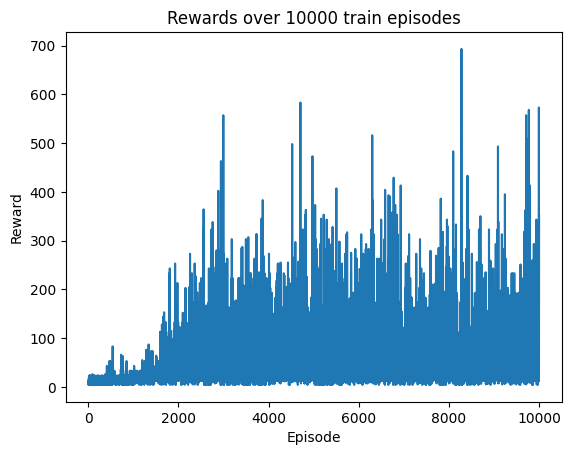

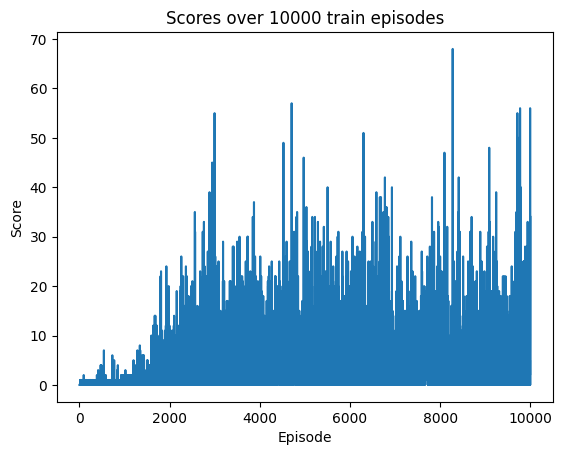

In [5]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Q_learning agent
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)

# train the Q_learning agent
train_rewards, train_scores = Q_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

In [6]:
labels = ["alpha = 0.1","alpha = 0.2","alpha = 0.3","alpha = 0.4", "alpha = 0.5","alpha = 0.6", "alpha = 0.7","alpha = 0.8", "alpha = 0.9"]
step_sizes = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for step_size in step_sizes:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=step_size,step_size_decay=1,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:21<00:00, 463.30it/s]


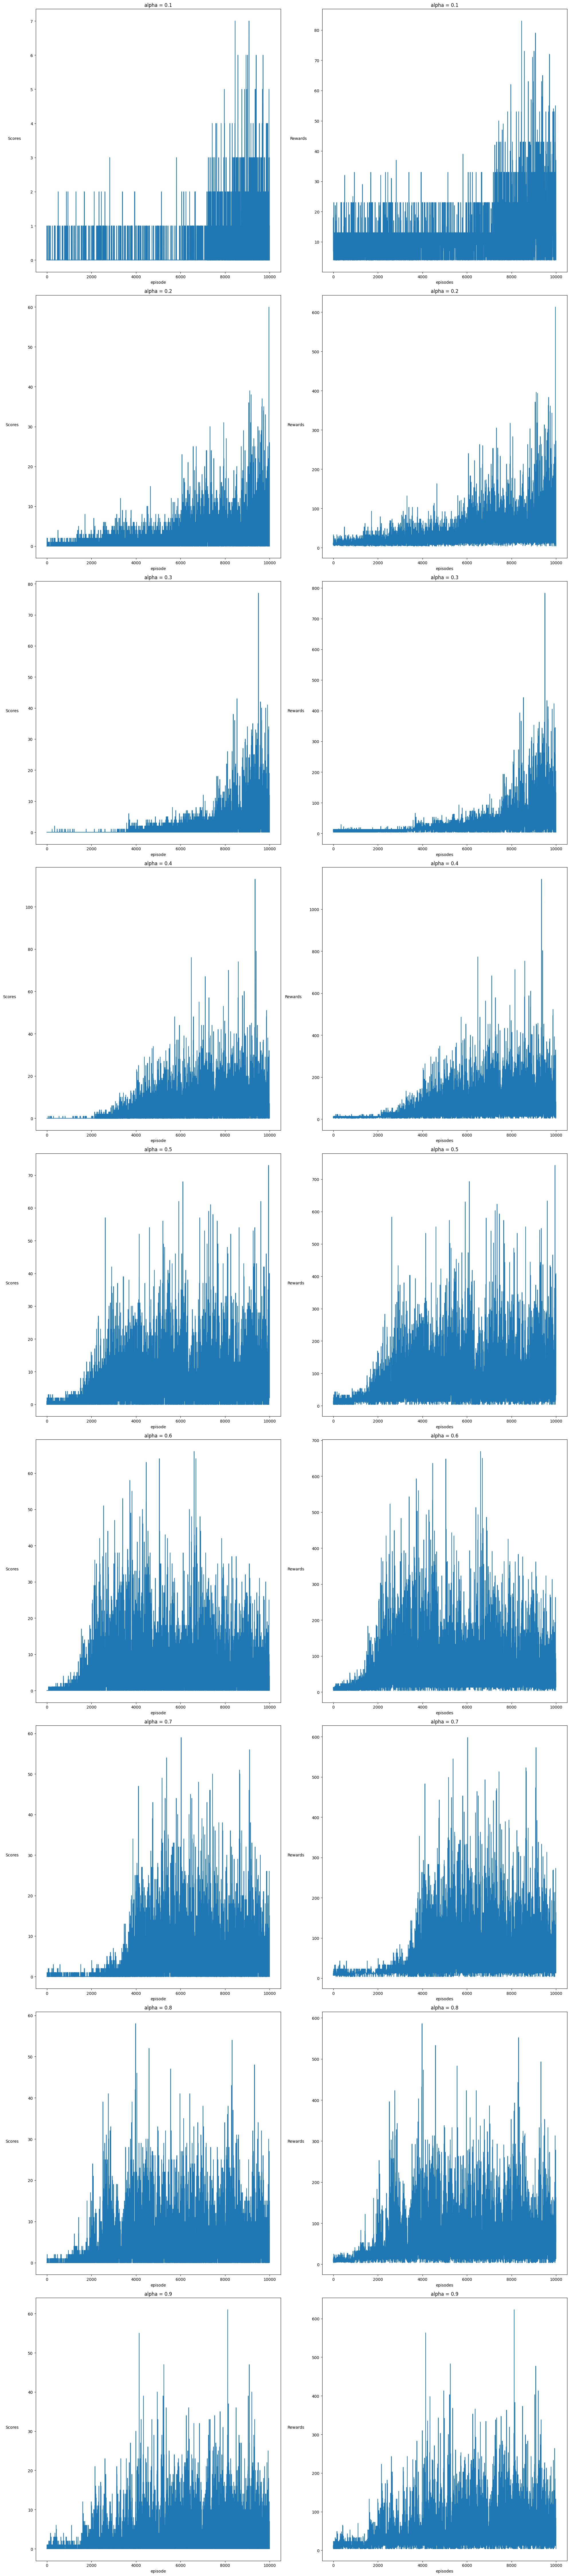

In [7]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [8]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label       │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════╪═════════════════╪═══════════════════╪════════════════╡
│ alpha = 0.1 │         11.9778 │                13 │             83 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.2 │         32.0398 │                22 │            613 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.3 │         27.1962 │                13 │            783 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.4 │         54.5533 │                26 │           1143 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.5 │         66.6836 │                43 │            743 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.6 │         62.9245 │                41 │            669 │
├─────

In [9]:
labels = ["epsilon = 0.05", "epsilon = 0.1","epsilon = 0.15", "epsilon = 0.2","epsilon = 0.25", "epsilon = 0.3"]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for epsilon in epsilons:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=epsilon,eps_decay=1,step_size=0.5,step_size_decay=1,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:14<00:00, 673.58it/s]


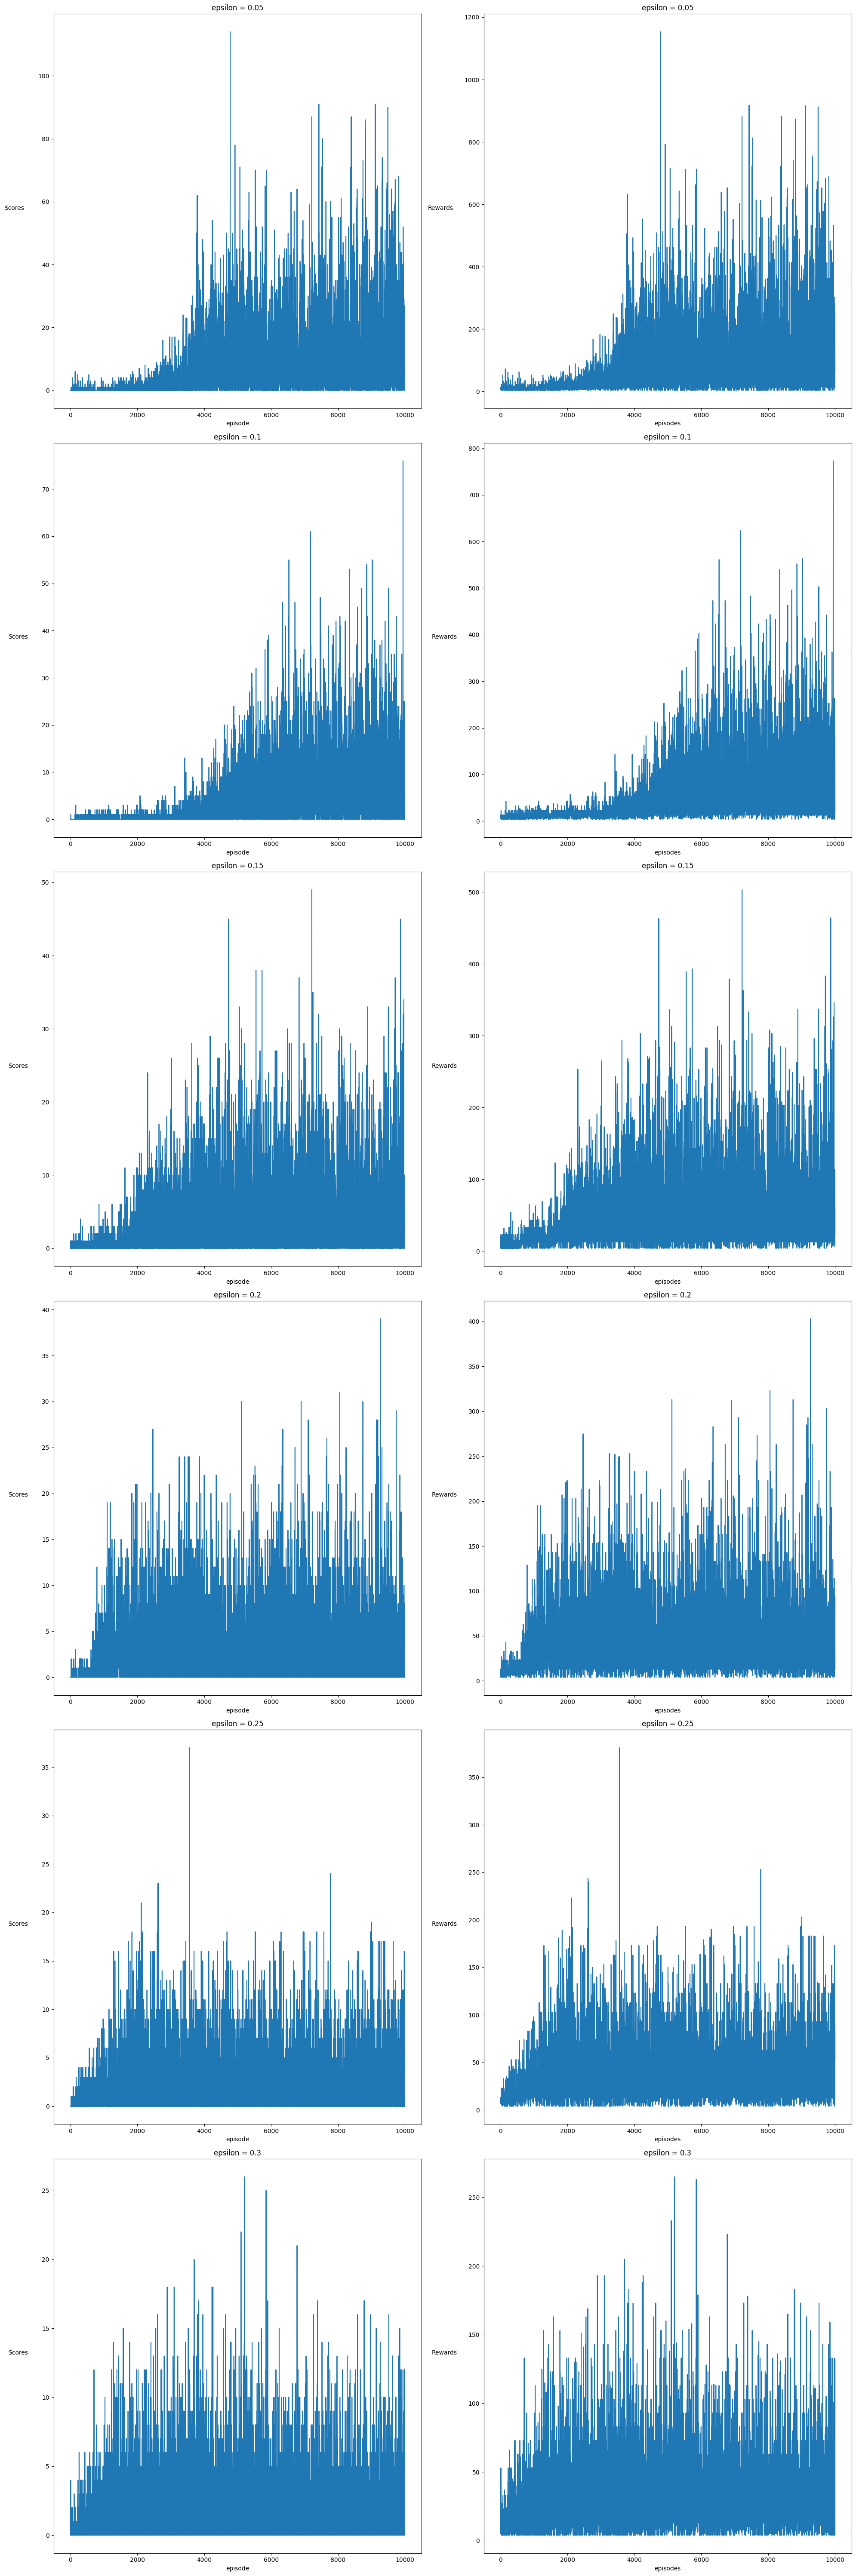

In [10]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [11]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label          │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ epsilon = 0.05 │         77.6016 │                37 │           1153 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.1  │         49.3016 │                23 │            773 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.15 │         47.6461 │                33 │            503 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.2  │         41.7204 │                32 │            403 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.25 │         35.3315 │                23 │            381 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.3  │         30.6407 │  

In [12]:
labels = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]
discounts = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for discount in discounts:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.5,step_size_decay=1,discount=discount,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:39<00:00, 252.71it/s]


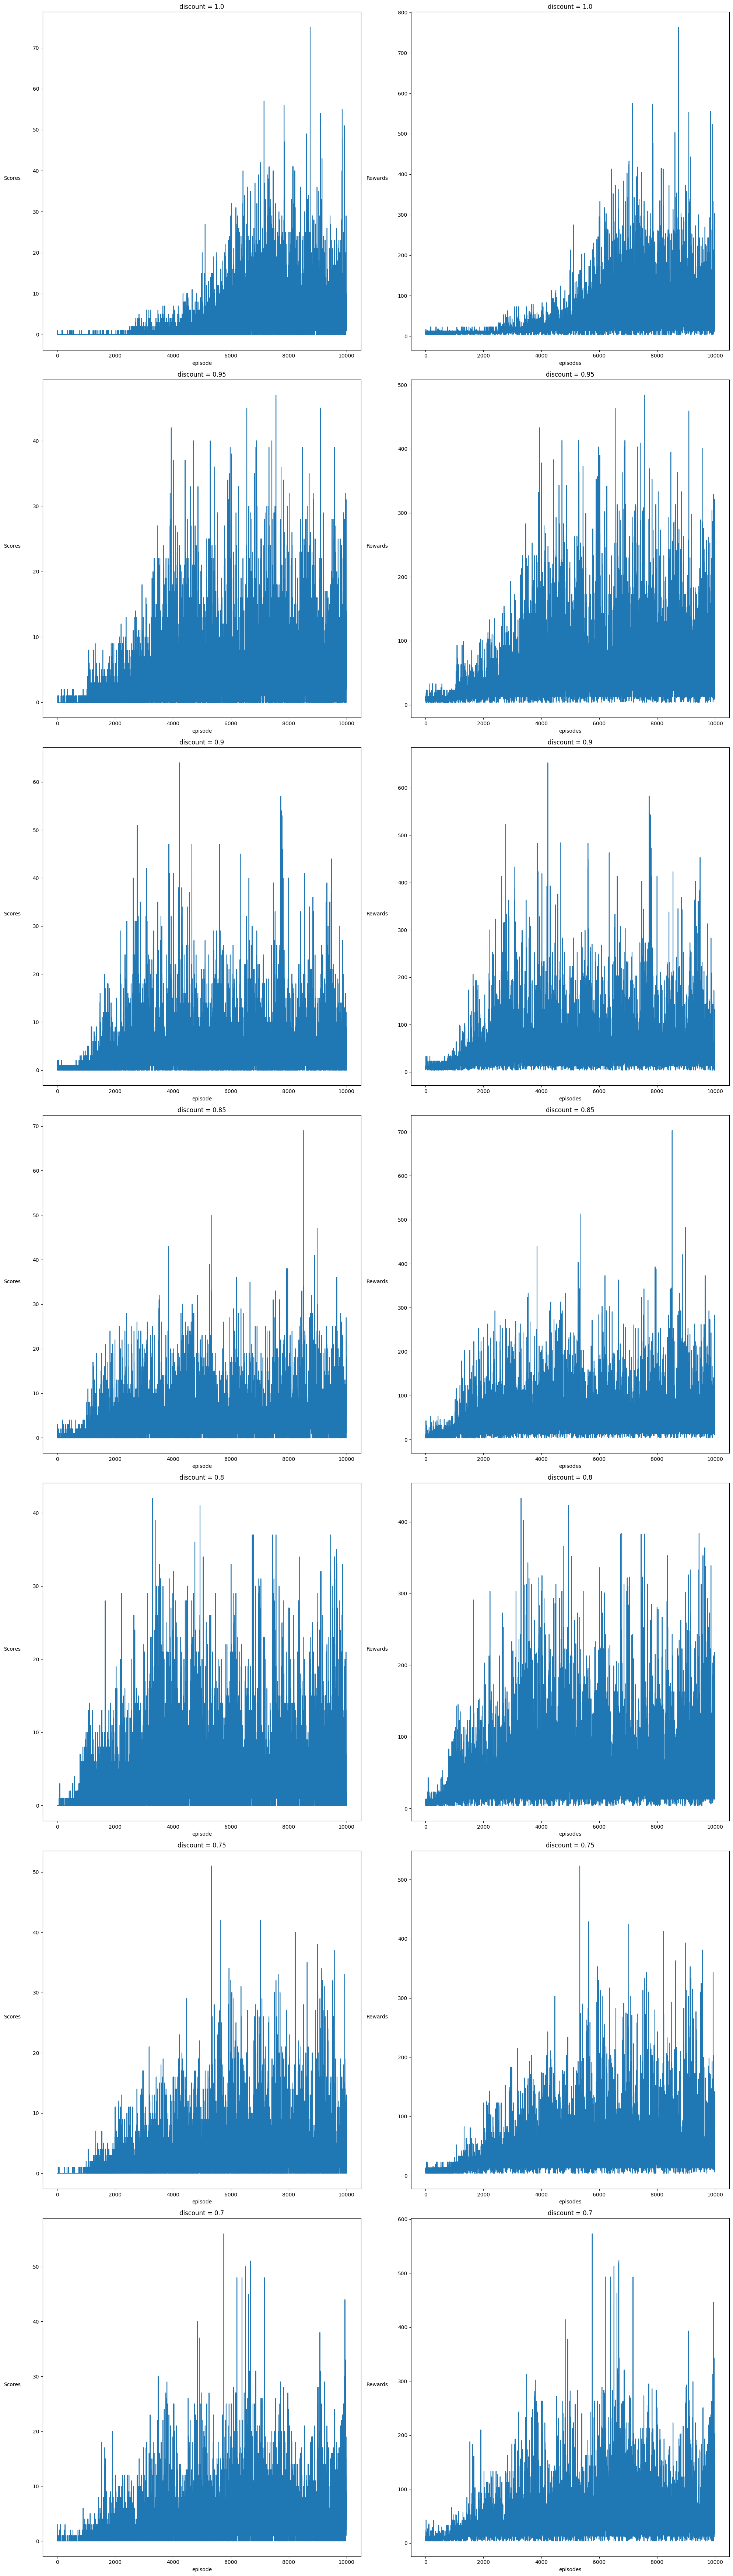

In [13]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [14]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label           │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ discount = 1.0  │         42.9406 │                20 │            763 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.95 │         51.7573 │                33 │            484 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.9  │         54.0057 │                33 │            653 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.85 │         50.8287 │                33 │            703 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.8  │         52.433  │                35 │            433 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.75 │      

In [15]:
labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999", "decay = 0.999","decay = 0.99", "decay =0.95", "decay = 0.9", "decay = 0.85"]
ss_decays = [1.0, 0.99999, 0.9999, 0.999, 0.99, 0.95, 0.9, 0.85]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for ss_decay in ss_decays:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.5,step_size_decay=ss_decay,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:08<00:00, 1230.45it/s]


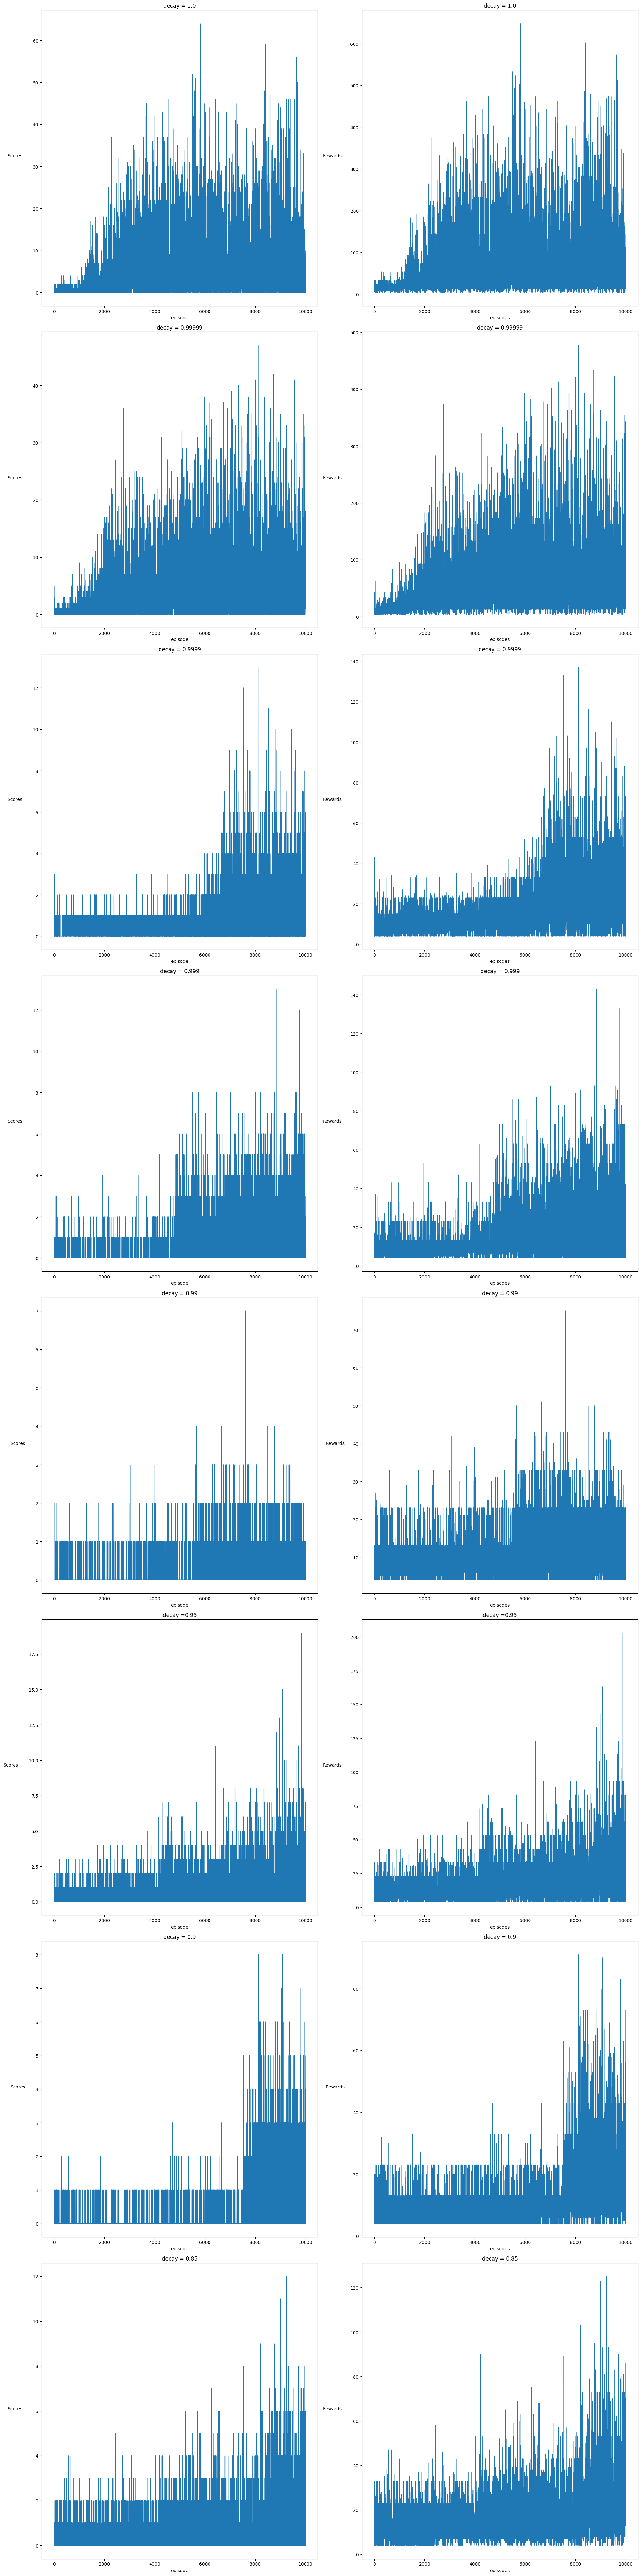

In [16]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [17]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label           │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ decay = 1.0     │         66.0321 │                43 │            648 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.99999 │         54.8929 │                37 │            477 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.9999  │         15.7793 │                13 │            137 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.999   │         15.6755 │                13 │            143 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.99    │         11.4035 │                11 │             75 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay =0.95     │      

In [18]:
labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999"]
eps_decays = [1.0, 0.99999,  0.9999 ]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for eps_decay in eps_decays:
    n_episodes = 5000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=eps_decay,step_size=0.5,step_size_decay=1,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 5000/5000 [00:02<00:00, 1979.14it/s]


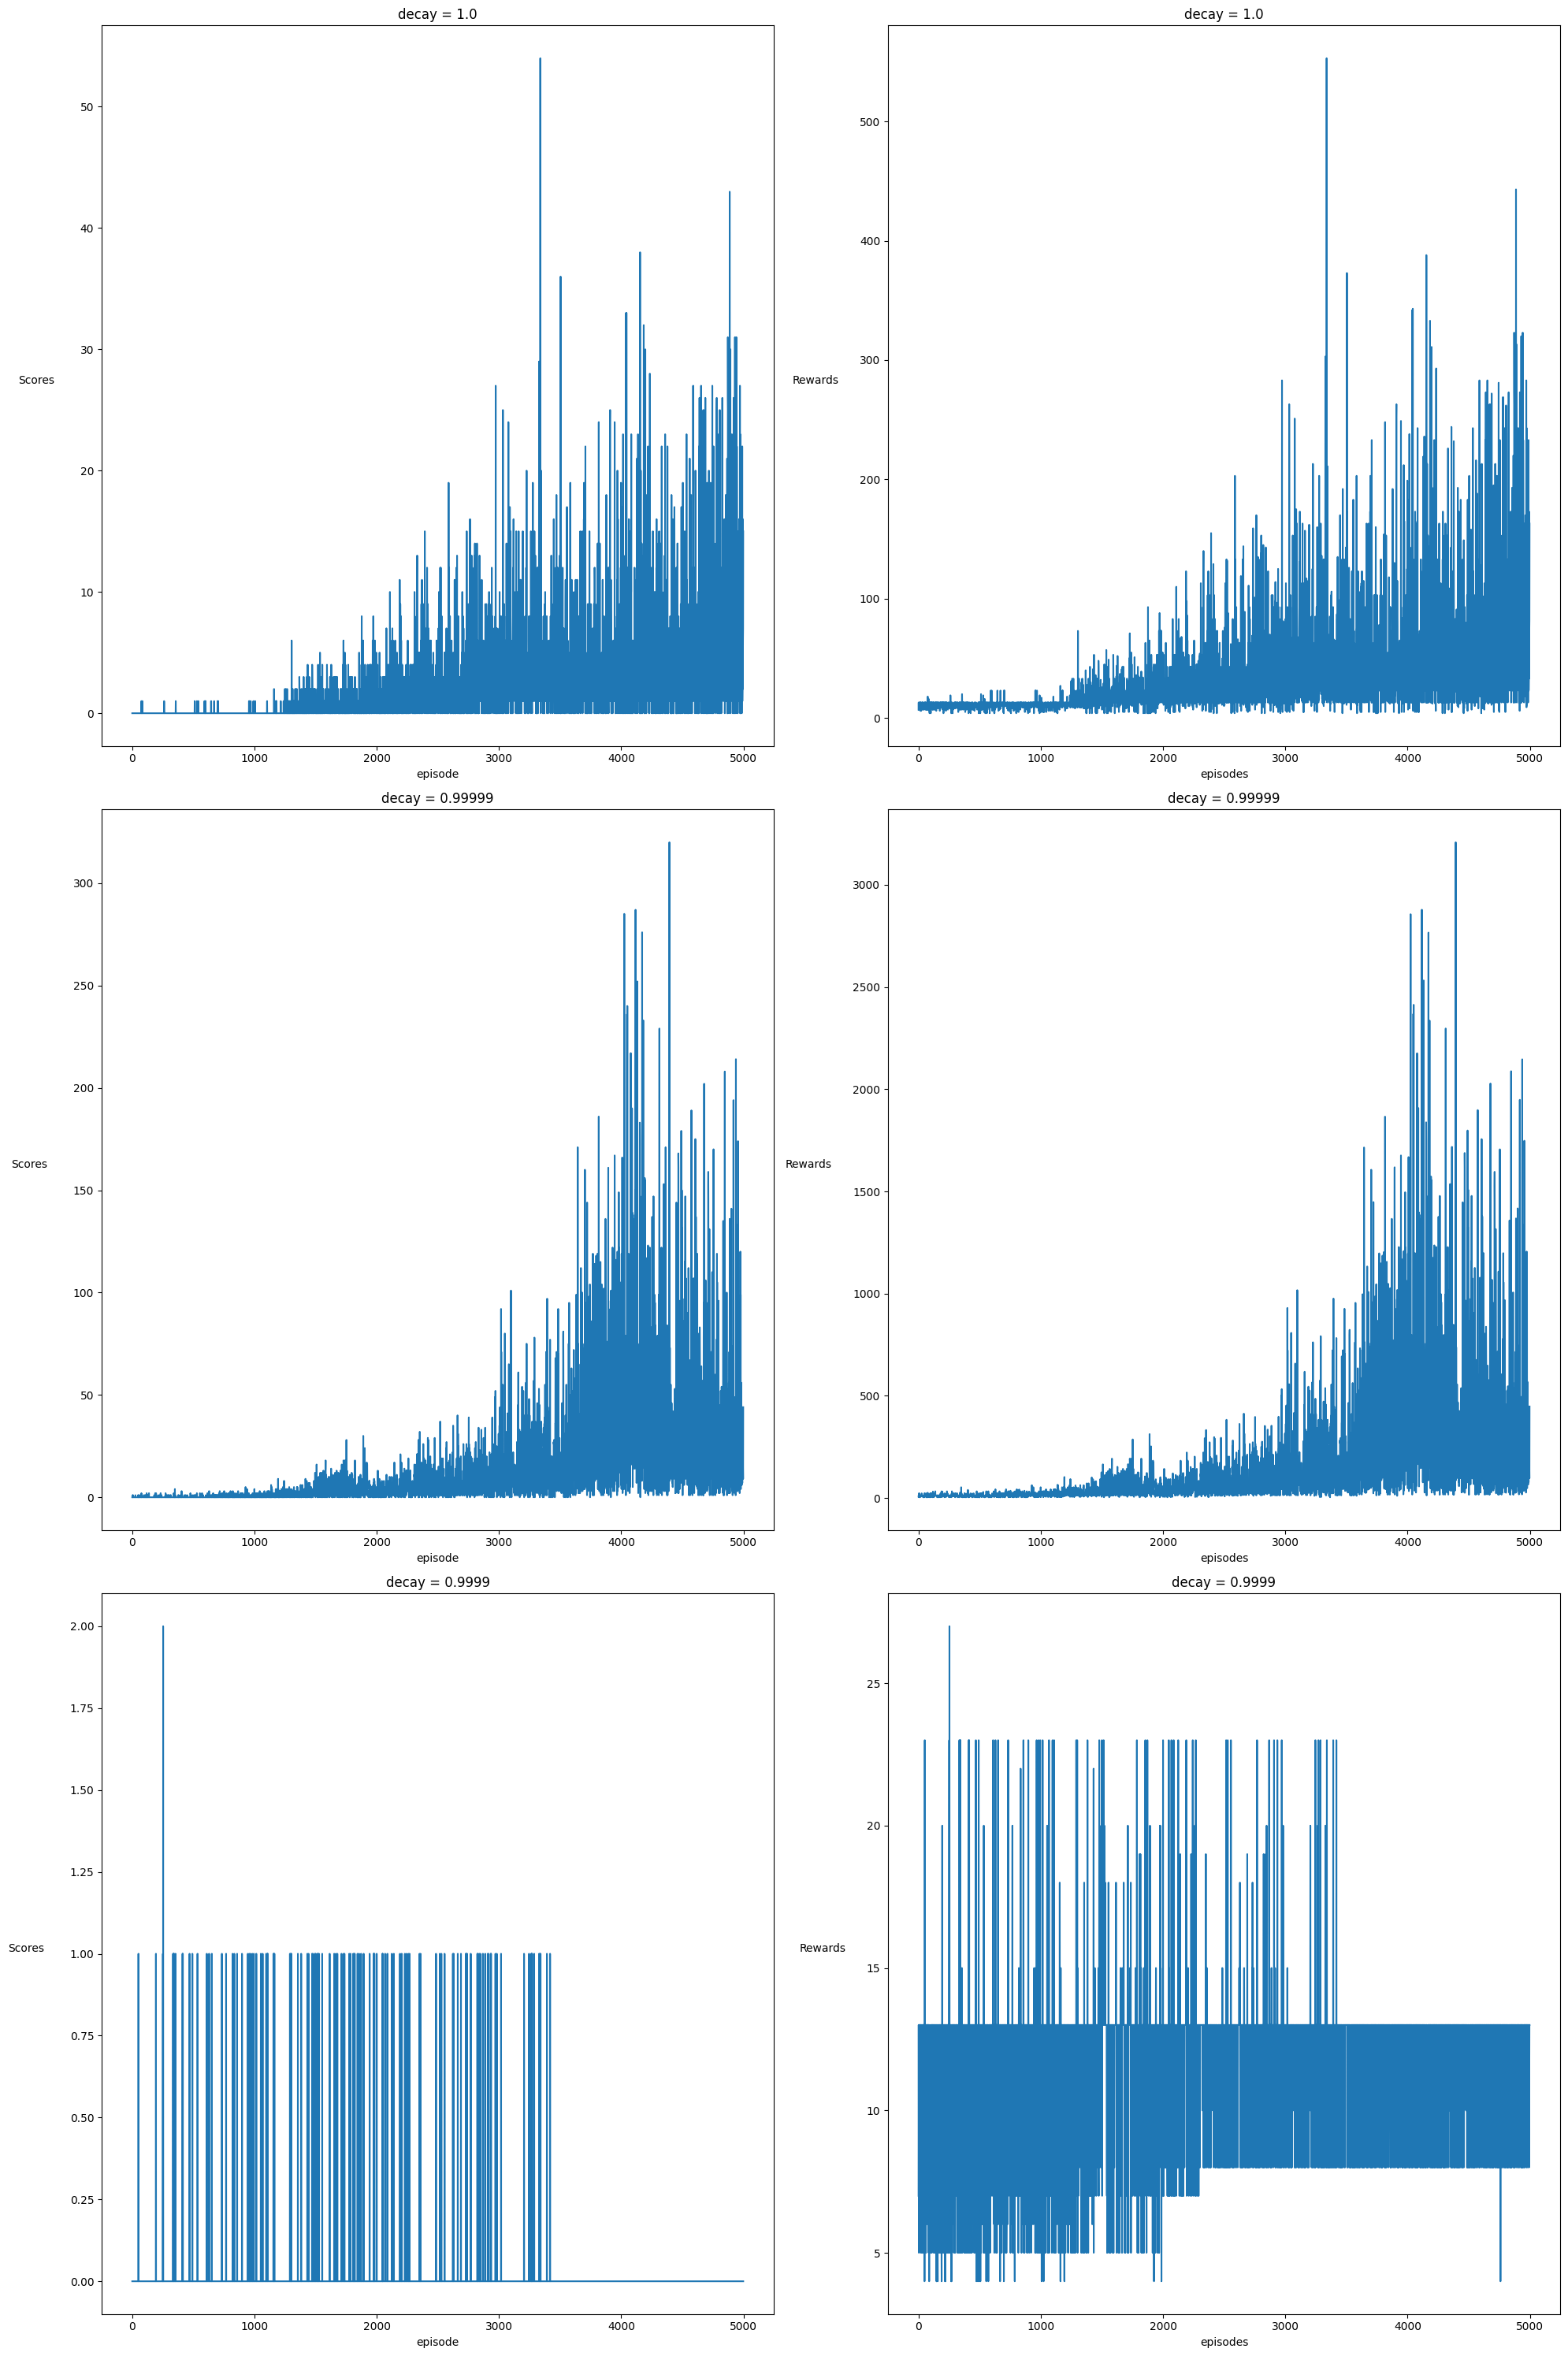

In [19]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [20]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label           │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ decay = 1.0     │         37.211  │                23 │            553 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.99999 │        156.329  │                45 │           3208 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.9999  │         11.5381 │                13 │             27 │
╘═════════════════╧═════════════════╧═══════════════════╧════════════════╛
╒═════════════════╤════════════════╤══════════════════╤═══════════════╕
│ Label           │   Mean(Scores) │   Median(Scores) │   Max(Scores) │
╞═════════════════╪════════════════╪══════════════════╪═══════════════╡
│ decay = 1.0     │      2.64453   │                1 │            54 │
├─────────────────┼────────────────┼─

100%|██████████| 20000/20000 [04:27<00:00, 74.84it/s] 


Average reward over 20000 train episodes: 275.84539226961346
Median reward over 20000 train episodes: 123.0
Average scores over 20000 train episodes: 26.436621831091554
Median scores over 20000 train episodes: 11.0


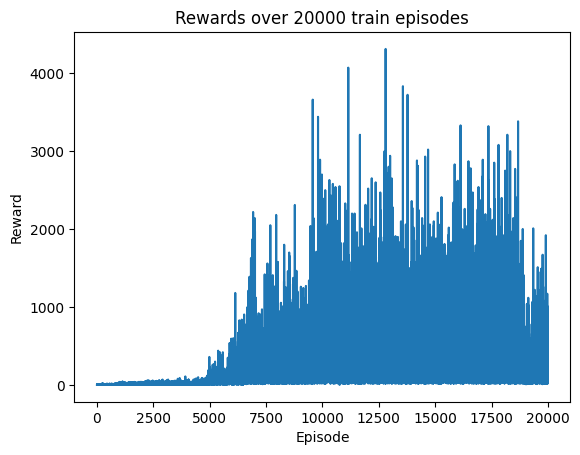

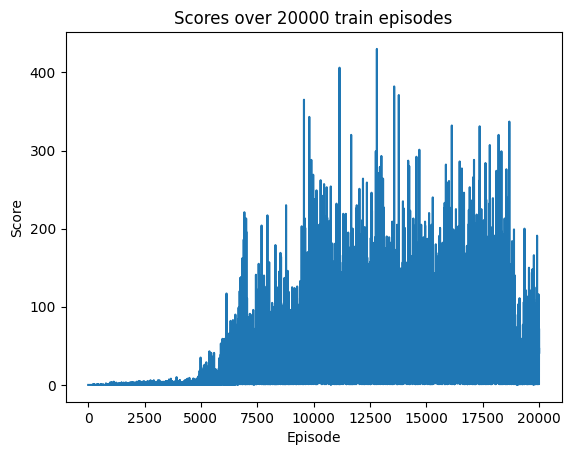

In [21]:
agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,step_size=0.5,step_size_decay=1,discount=1,seed=0)

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
n_episodes=20000
# train the QLearning agent
train_rewards, train_scores = agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

100%|██████████| 100/100 [00:01<00:00, 87.68it/s]


Average reward over 100 test episodes: 360.42
Median reward over 100 test episodes: 237.0
Average scores over 100 test episodes: 34.79
Median scores over 100 test episodes: 22.5


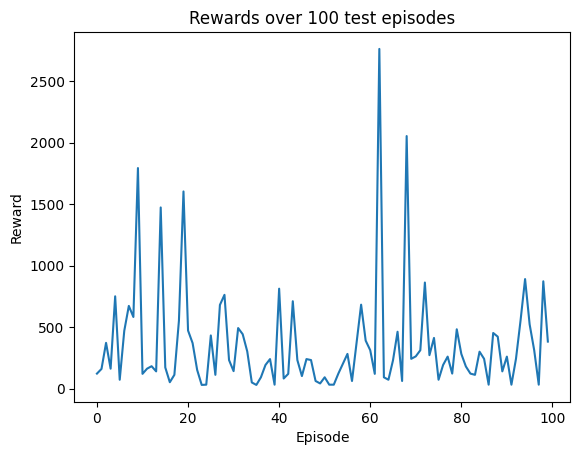

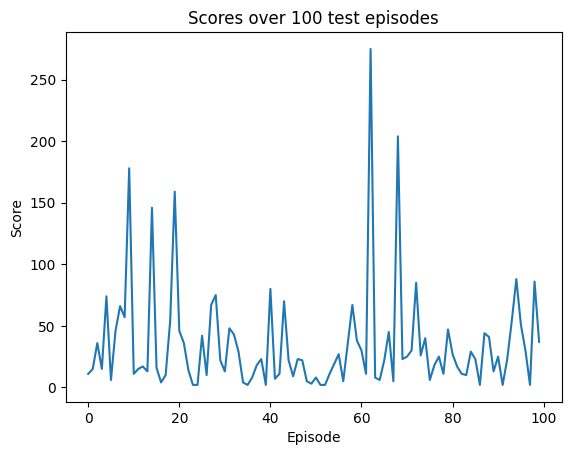

In [22]:
# test the trained agent for 100 episodes
n_episodes=100
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
test_rewards,test_scores = agent.test(env,n_episodes=n_episodes)
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()